In [97]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

# PHẦN 1: KHÁM PHÁ DỮ LIỆU

In [98]:
# Đọc và in dữ liệu ban đầu
data = pd.read_csv('Market Basket Analysis 4.csv', header=None, dtype=str)
data

,0,1,2,3,4,5,6,7,8,9,10
0,whole milk,pastry,salty snack,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sausage,whole milk,semi-finished bread,yogurt,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,soda,pickled vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,canned beer,misc. beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sausage,hygiene articles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
14958,butter milk,whipped/sour cream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14959,bottled water,herbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14960,fruit/vegetable juice,onions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14961,bottled beer,other vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Khi sử dụng data frame dạng bảng sẽ khó xử lý theo từng giao dịch => chuyển đổi thành các danh sách giao dịch

In [99]:
# Tìm tất cả các giá trị chứa dấu "/"
values_with_slash = set()  # Dùng set để lưu giá trị không trùng lặp

for column in data.columns:  #
    matches = data[column][data[column].astype(str).str.contains("/", na=False)]
    values_with_slash.update(matches.tolist())  

print('Danh sách tên các mặt hàng có dấu "/":')
print(values_with_slash)

Danh sách tên các mặt hàng có dấu "/":
{'cling film/bags', 'whipped/sour cream', 'rolls/buns', 'red/blush wine', 'fruit/vegetable juice', 'photo/film', 'packaged fruit/vegetables', 'nuts/prunes', 'flower soil/fertilizer'}


Nhận thấy dấu '/' được dùng để nhóm các sản phẩm chung vào cùng một loại hàng hóa. Đây không phải là dấu phân tách hai mặt hàng riêng biệt => không cần tách riêng ra.

In [123]:
# Kết hợp tất cả các mặt hàng trong tập dữ liệu
all_items = data.stack().dropna().tolist()

# Loại bỏ các mặt hàng giống nhau
unique_items = set(all_items)

total_unique_items = len(unique_items)
print("Tổng số lượng mặt hàng trong tất cả giao dịch:", total_unique_items)

Tổng số lượng mặt hàng trong tất cả giao dịch: 167


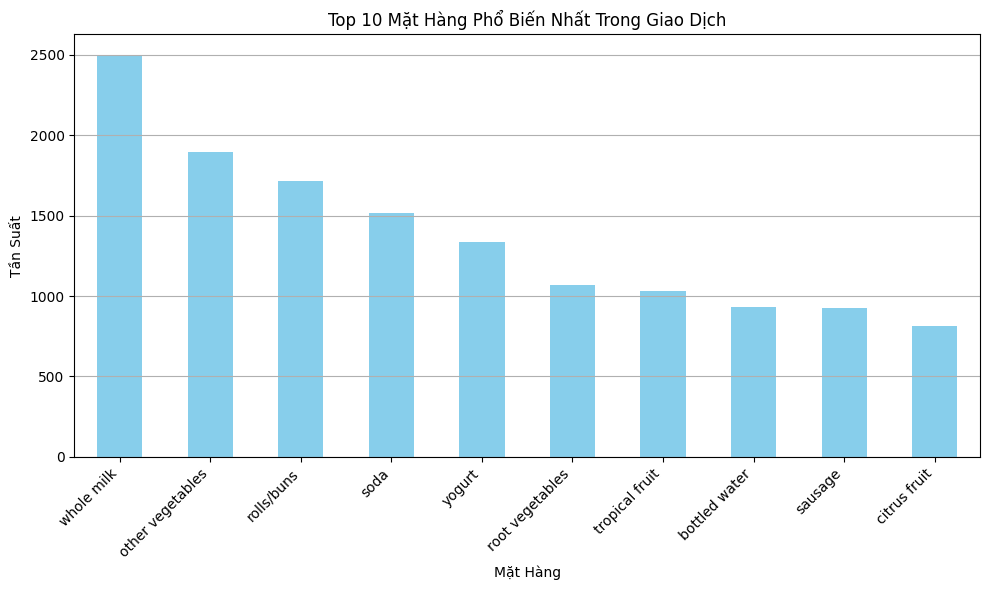

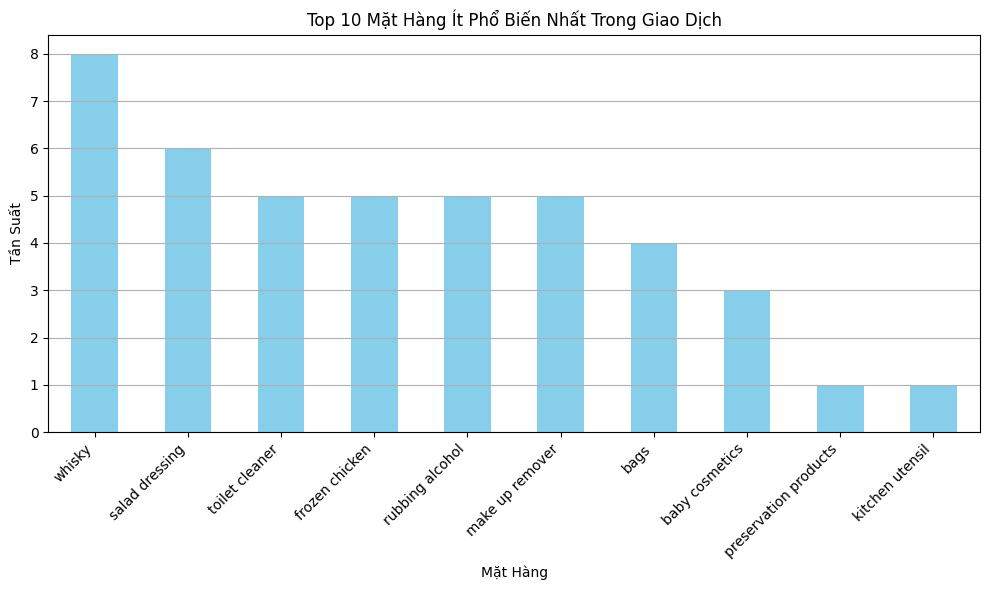

In [101]:
# Kết hợp tất cả các mặt hàng để tính tần suất
all_items = data.stack().dropna().tolist()
item_frequencies = pd.Series(all_items).value_counts()

# Vẽ biểu đồ tần suất của 10 mặt hàng phổ biến nhất
top_items = item_frequencies.head(10)

# Thiết lập biểu đồ
plt.figure(figsize=(10, 6))
top_items.plot(kind='bar', color='skyblue')
plt.title("Top 10 Mặt Hàng Phổ Biến Nhất Trong Giao Dịch")
plt.xlabel("Mặt Hàng")
plt.ylabel("Tần Suất")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Vẽ biểu đồ tần suất của 10 mặt hàng phổ biến nhất
bot_items = item_frequencies.tail(10)

# Thiết lập biểu đồ
plt.figure(figsize=(10, 6))
bot_items.plot(kind='bar', color='skyblue')
plt.title("Top 10 Mặt Hàng Ít Phổ Biến Nhất Trong Giao Dịch")
plt.xlabel("Mặt Hàng")
plt.ylabel("Tần Suất")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

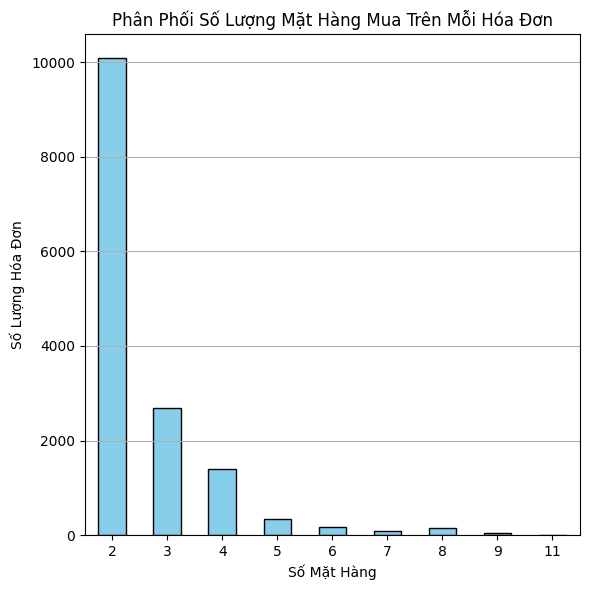

In [102]:
# Đếm số mặt hàng không phải NaN trên mỗi hóa đơn
item_counts_per_invoice = data.notna().sum(axis=1)

# Đếm số lần xuất hiện của mỗi số lượng mặt hàng
item_count_distribution = item_counts_per_invoice.value_counts().sort_index()

# Vẽ biểu đồ cột
plt.figure(figsize=(6, 6))
item_count_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Phân Phối Số Lượng Mặt Hàng Mua Trên Mỗi Hóa Đơn")
plt.xlabel("Số Mặt Hàng")
plt.ylabel("Số Lượng Hóa Đơn")
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# PHẦN 2: CHUYỂN ĐỔI DỮ LIỆU 

In [103]:
# Đọc file CSV và chuyển thành danh sách giao dịch
def read_transactions_from_csv(file_path):
    transactions = []
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            transactions.append([item.strip() for item in row if item.strip()])
    return transactions

In [104]:
# Chuyển đổi giao dịch từ dạng ngang sang dạng dọc
def convert_to_vertical_format(transactions):
    vertical_db = {}
    for transaction_id, transaction in enumerate(transactions):
        unique_items = set(transaction)
        for item in unique_items:
            if item not in vertical_db:
                vertical_db[item] = []
            vertical_db[item].append(transaction_id)
    return vertical_db

In [105]:
# Tạo ra bảng cho các giao dịch để trực quan
def transactions_table(transactions):
    data = {'Transaction': [', '.join(map(str, transaction)) for transaction in transactions]}
    
    df = pd.DataFrame(data)
    return df

In [106]:
# Tạo ra bảng cho vertical_transactions để trực quan
def vertical_transactions_table(vertical_db):
    vertical_data = {
        'Item': [item for item in vertical_db.keys()],
        'Transactions': [', '.join(map(str, transactions)) for transactions in vertical_db.values()]
    }
    
    df = pd.DataFrame(vertical_data)
    return df

In [107]:
# Đọc file và chuyển đổi thành danh sách giao dịch
transactions = read_transactions_from_csv('Market Basket Analysis 4.csv')

# In và kiểm tra danh sách giao dịch
df_transactions = transactions_table(transactions)
print("Transactions:")
df_transactions

Transactions:


,Transaction
0,"whole milk, pastry, salty snack"
1,"sausage, whole milk, semi-finished bread, yogurt"
2,"soda, pickled vegetables"
3,"canned beer, misc. beverages"
4,"sausage, hygiene articles"
...,...
14958,"butter milk, whipped/sour cream"
14959,"bottled water, herbs"
14960,"fruit/vegetable juice, onions"
14961,"bottled beer, other vegetables"


In [109]:
# Chuyển đổi danh sách giao dịch sang dạng dọc
vertical_db = convert_to_vertical_format(transactions)

# In và kiểm tra vertical db
df_vertical = vertical_transactions_table(vertical_db)
print("\nVertical Database:")
df_vertical


Vertical Database:


,Item,Transactions
0,pastry,"0, 21, 37, 43, 117, 121, 164, 202, 277, 292, 3..."
1,salty snack,"0, 63, 101, 144, 212, 219, 326, 330, 387, 392,..."
2,whole milk,"0, 1, 5, 6, 10, 20, 21, 24, 29, 31, 45, 48, 51..."
3,semi-finished bread,"1, 264, 379, 404, 478, 737, 752, 780, 807, 950..."
4,sausage,"1, 4, 5, 17, 60, 87, 91, 99, 123, 132, 140, 21..."
...,...,...
162,frozen chicken,"3085, 6883, 8513, 10776, 13827"
163,salad dressing,"3974, 4305, 5882, 6906, 7716, 8799"
164,specialty vegetables,"3990, 4044, 7743, 7805, 8828, 10775, 10782, 11..."
165,toilet cleaner,"4990, 5524, 8408, 10991, 13781"


# PHẦN 3: THUẬT TOÁN ECLAT VÀ LUẬT KẾ HỢP

In [111]:
def eclat_algorithm(vertical_db, total_transactions, min_sup):  
    # Lọc ra items và tid_lists có frequency >= min_sup * total_transactions
    items, tid_lists = zip(*[(key, set(tid_list)) for key, tid_list in vertical_db.items() if len(tid_list) >= min_sup * total_transactions])
    
    # Tạo hàm để thực hiện đệ qui
    def find_frequent_itemsets(prefix, items, tid_lists, min_sup, frequent_itemsets):
        if not items:
            return frequent_itemsets
        
        for i in range(len(items)):
            item = items[i]
            tid_list = tid_lists[i]
            support = len(tid_list) / total_transactions
            
            # Kiểm tra điều kiện min_sup
            if support >= min_sup:
                frequent_itemsets.append((prefix + [item], support))
                    
                new_prefix = prefix + [item]
                new_items = items[i + 1:]
                new_tid_lists = [
                    tid_list & other_tid_list
                    for other_tid_list in tid_lists[i + 1:]
                ]
                
                find_frequent_itemsets(new_prefix, new_items, new_tid_lists, min_sup, frequent_itemsets)
                
        return frequent_itemsets
    
    frequent_itemsets = find_frequent_itemsets([], items, tid_lists, min_sup, [])
    
    return frequent_itemsets

In [112]:
# Sinh ra các luật kết hợp từ các itemsets phổ biến
def association_rules(frequent_itemsets, min_confidence):
    rules = []
    
    # Tạo thư viện để lưu frequency theo các itemset phổ biến
    freq_dict = {frozenset(itemset): support for itemset, support in frequent_itemsets}
    
    for itemset, support in frequent_itemsets:
        if len(itemset) >= 2:
            for i in range(1, len(itemset)):
                for subset in combinations(itemset, i):
                    antecedent = set(subset)
                    consequent = set(itemset) - antecedent
                    
                    if not consequent:
                        continue
                    
                    supp_antecedent = freq_dict.get(frozenset(antecedent), 0)
                    supp_consequent = freq_dict.get(frozenset(consequent), 0)
                    
                    # Tính confidence
                    confidence = (support / supp_antecedent)  if supp_antecedent > 0 else 0
                    
                    # Tính lift
                    lift = (support / (supp_antecedent * supp_consequent)) if supp_antecedent >= 0 and supp_consequent >= 0 else 0
                    
                    if confidence >= min_confidence:
                        rules.append((antecedent, consequent, support, confidence, lift))
                    
    return rules

In [113]:
# Tạo ra bảng cho các itemsets phổ biến để trực quan
def frequent_itemsets_table(frequent_itemsets):
    data = {
        'Frequent Itemsets': [', '.join(itemset) for itemset, _ in frequent_itemsets if len(itemset) > 1],
        'Support': [f'{support:.6f}' for itemset, support in frequent_itemsets if len(itemset) > 1]}
    
    df = pd.DataFrame(data)
    return df

In [114]:
# Tạo ra bảng cho các luật kết hợp để trực quan
def association_rules_table(association_rules):
    data = {
        'Antecedents': [', '.join(map(str, antecedents)) for antecedents, _, _, _, _ in association_rules],
        'Consequents': [', '.join(map(str, consequents)) for _, consequents, _, _, _ in association_rules],
        'Support': [f'{support:.6f}' for _, _, support, _, _ in association_rules],
        'Confidence': [f'{confidence:.6f}' for _, _, _, confidence, _ in association_rules],
        'Lift': [f'{lift:.6f}' for _, _, _, _, lift in association_rules]}
    
    df = pd.DataFrame(data)
    return df

Cài đặt NGƯỠNG HỖ TRỢ và ĐỘ TIN CẬY TỐI THIỂU

In [115]:
# Ngưỡng hỗ trợ và độ tin cậy tối thiểu
min_sup = 0.0005
min_confidence = 0.1
total_transactions = len(transactions) # Cần tổng số giao dịch để hỗ trợ tính toán cho support

In [116]:
#  Chạy thuật toán Eclat để tìm tập phổ biến
frequent_itemsets = eclat_algorithm(vertical_db, total_transactions, min_sup)

In [117]:
# Sinh các luật kết hợp
association_rules = association_rules(frequent_itemsets, min_confidence)

IN KẾT QUẢ

In [118]:
# In Min Support và Min Confidence đã chọn
print(f"Min Support: {min_sup}")
print(f"Min Confidence: {min_confidence}\n")

Min Support: 0.0005
Min Confidence: 0.1



In [119]:
# In bảng Frequent Itemsets
print("Frequent Itemsets:")
df_frequent_table = frequent_itemsets_table(frequent_itemsets)
df_frequent_table

Frequent Itemsets:


,Frequent Itemsets,Support
0,"pastry, salty snack",0.000668
1,"pastry, whole milk",0.006483
2,"pastry, whole milk, sausage",0.000735
3,"pastry, whole milk, yogurt",0.000601
4,"pastry, whole milk, soda",0.000936
...,...,...
1284,"long life bakery product, pork",0.000869
1285,"beverages, pork",0.000601
1286,"berries, cream cheese",0.000535
1287,"cream cheese, pork",0.000668


In [120]:
# In bảng Association Rules
print("Association Rules:")
df_association_rules_table = association_rules_table(association_rules)
df_association_rules_table

Association Rules:


,Antecedents,Consequents,Support,Confidence,Lift
0,pastry,whole milk,0.006483,0.125323,0.793571
1,"pastry, whole milk",sausage,0.000735,0.113402,1.879109
2,"pastry, sausage",whole milk,0.000735,0.229167,1.451130
3,"pastry, yogurt",whole milk,0.000601,0.166667,1.055367
4,"pastry, whole milk",soda,0.000936,0.144330,1.486310
...,...,...,...,...,...
289,sweet spreads,tropical fruit,0.000735,0.161765,2.387066
290,processed cheese,root vegetables,0.001069,0.105263,1.513019
291,turkey,root vegetables,0.000601,0.112500,1.617039
292,sweet spreads,pip fruit,0.000535,0.117647,2.398301
